## Imports

In [5]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os
import sys

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Misc Utilities

In [6]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-9

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l

class DiagNLLLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(DiagNLLLoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        y_predictions, y_sigmas = y_pred

        l = torch.log(torch.prod(y_sigmas, dim=1) + self.eta)*y_predictions.shape[0] + torch.sum(torch.sum(torch.pow((y_true - y_predictions), 2)/ y_sigmas, dim=1), dim=0)

        return l



## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


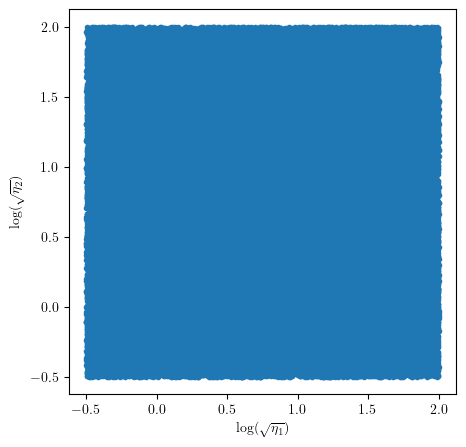

In [8]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = True
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([-0.5, 0.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="d_condition", noise_type="out_noise", d_condition=">=", noise=0.001**2)

etas_test, gs_test = generate_log_data(SSG_gen, log, 10_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [4]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32)

## Network Training

In [5]:
# Defining model parameters
chkpt_prefix = 'D_GT_0'
chkpt_dir = '../Model_Checkpoints/Ensemble/Aleatoric/' + chkpt_prefix + '/'


net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
        "out_noise": True,
}

train_params = {
        "criterion": DiagNLLLoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 1e-6,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 500,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 0,
}

num_members = 40

In [11]:
test_criteria = RMSELoss()

for i in range(num_members):
    net_name = chkpt_prefix + f'_Ens_{i}.pt'

    callbacks = [EarlyStopping(patience=15, threshold=0.000001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
        Checkpoint(monitor='valid_loss_best', f_params=net_name, dirname=chkpt_dir),
        LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.000001, threshold_mode='abs', mode='min', verbose=True)
    ]
    train_params['callbacks'] = callbacks

    net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    net = net.fit(x_train, y_train)

    net.load_params(f_params=chkpt_dir+net_name)
    with torch.no_grad():
        test_pred = net.predict(x_test)
    print(f"\t\tTest loss: {test_criteria(test_pred, y_test)}")

/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


		Test loss: 0.006245093885809183
		Test loss: 0.004890983924269676
		Test loss: 0.005535355303436518
		Test loss: 0.005545090883970261
		Test loss: 0.005732195917516947
		Test loss: 0.006072992458939552
		Test loss: 0.005088280886411667
		Test loss: 0.00788769032806158
		Test loss: 0.005341876298189163
		Test loss: 0.006110834423452616
		Test loss: 0.004615136422216892
		Test loss: 0.006990392692387104
		Test loss: 0.00680393585935235
		Test loss: 0.006932006683200598
		Test loss: 0.006146849133074284
		Test loss: 0.004319876432418823
		Test loss: 0.006693402770906687
		Test loss: 0.006583515554666519
		Test loss: 0.00644710985943675
		Test loss: 0.004412594251334667
		Test loss: 0.007591362111270428
		Test loss: 0.007567235734313726
		Test loss: 0.005459839478135109
		Test loss: 0.004554838873445988
		Test loss: 0.005035671405494213
		Test loss: 0.005993351805955172
		Test loss: 0.00622352072969079
		Test loss: 0.008086071349680424


## Creating Ensemble

In [6]:
chkpt_prefix = 'Regular'
chkpt_dir = '../Model_Checkpoints/Ensemble/Aleatoric/' + chkpt_prefix + '/'
ensemble = []

for i in range(num_members):
    net = reinitialize_model(chkpt_prefix + f'_Ens_{i}.pt', chkpt_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    ensemble.append(net)

#test_criteria = nn.MSELoss()
#mse_list = np.zeros(num_members)
#for i, net in enumerate(ensemble):
#    pred = net.predict(x_test)
#    mse = test_criteria(torch.tensor(pred, device=device), y_test.to(device=device))
#    mse_list[i] = mse.item()
#
#weights = np.exp(-mse_list) / np.sum(np.exp(-mse_list))
#
#print("MSE List: ", mse_list)
#print("Weights: ", weights)
#print("Sum of Weights: ", weights.sum())

## Generating Statistics Data

0.0003029027919520125


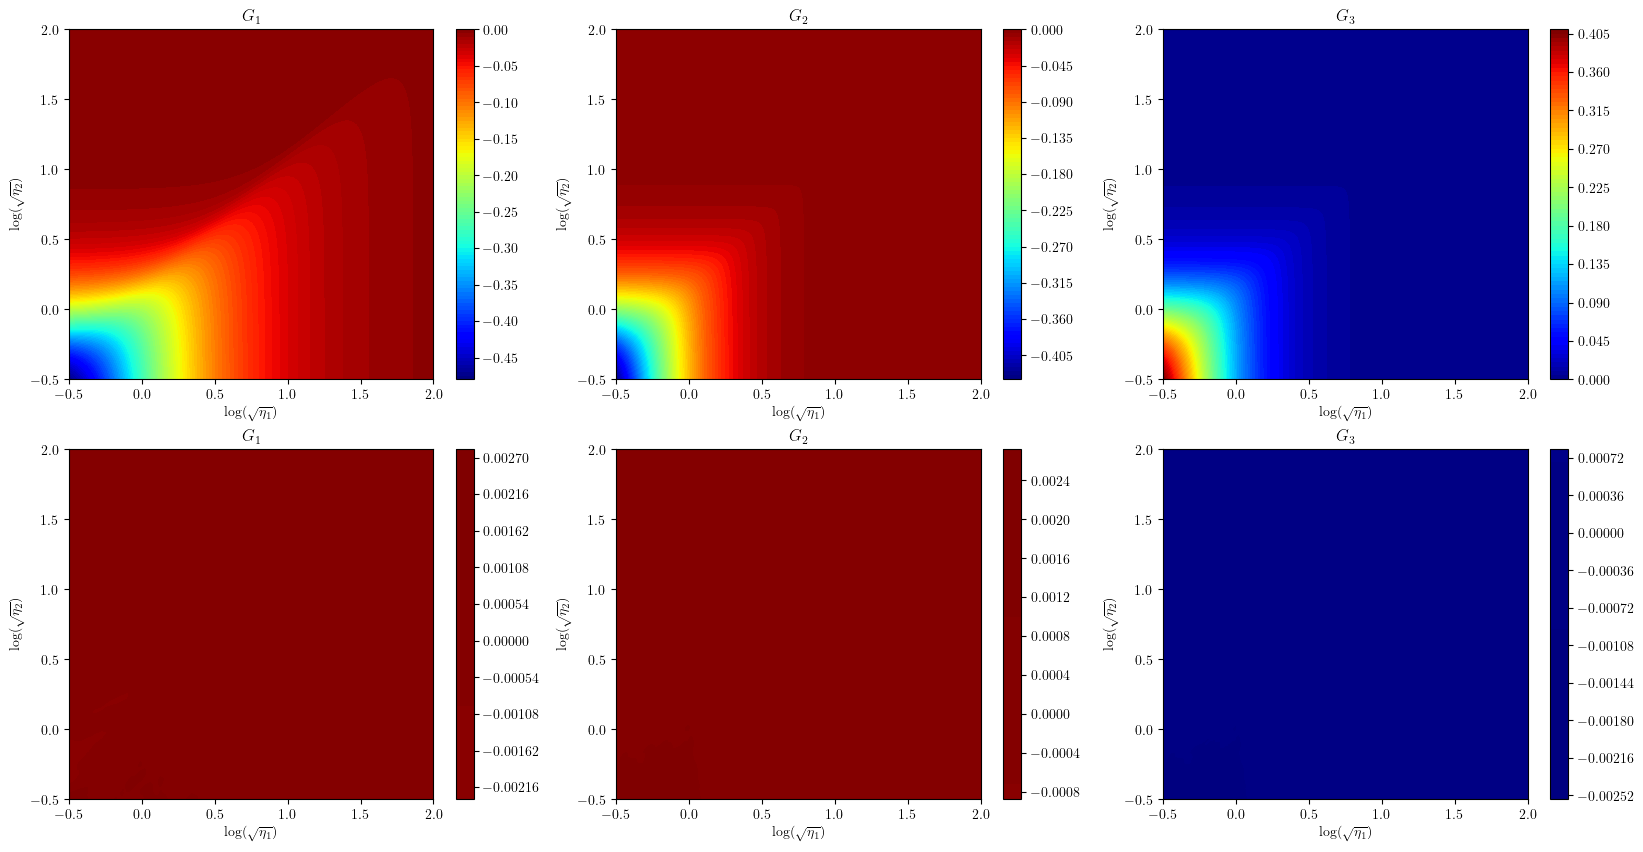

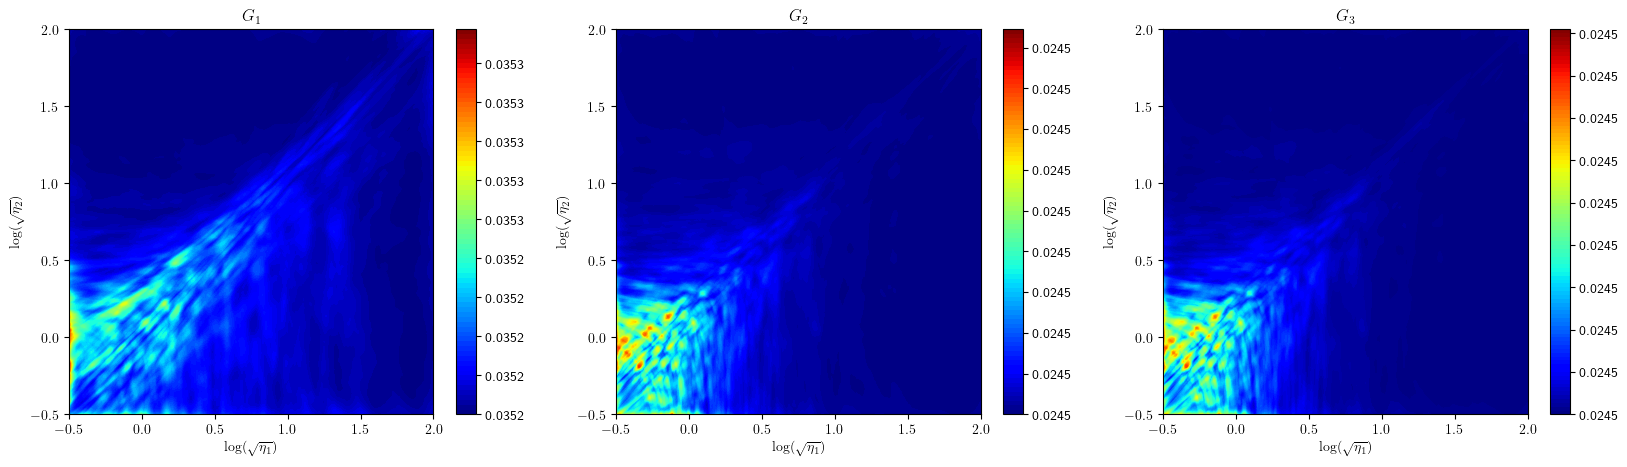

In [7]:
test_criteria = RMSELoss()
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

preds = np.zeros((num_members, len(etas), 3))
stds = np.zeros((num_members, 3))
for i in range(num_members):
    pred = ensemble[i].predict(etas.astype(np.float32))
    preds[i] = y_scaler.inverse_transform(pred)
    stds[i] = ensemble[i].module_.sigma.detach().cpu().numpy()


#pred_test = np.tensordot(weights.reshape(1,-1), preds, axes=(1, 0)).squeeze()
pred = preds.mean(axis=0)

std = preds.std(axis=0)

if net_params['out_noise']:
    std = np.sqrt(std**2 + stds.mean(axis=0)**2)

chkpt_prefix += "_Alea"
np.savetxt('../data/Ensemble/' + chkpt_prefix + '_Pred_Mean.csv', pred, delimiter=',')
np.savetxt('../data/Ensemble/' + chkpt_prefix + '_Pred_Std.csv', std, delimiter=',')

#rmse_test = test_criteria(torch.tensor(target), torch.tensor(pred_test).T.reshape(3, dim, dim)).item()
rmse = test_criteria(torch.tensor(target), torch.tensor(pred).T.reshape(3, dim, dim)).item()

#print(rmse_test)
print(rmse)


plot_heat_map_compare(x_grid, y_grid, target, (target -pred.T.reshape(3, dim, dim)), 'Algebraic', 'Ensemble', sup_title=False)

plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim), "Ensemble Standard Deviation", sup_title=False)

In [9]:
print(pred.max(), pred.min())

0.40880668684840205 -0.4823658108711243


## Reload Runs

0.02232117474062385


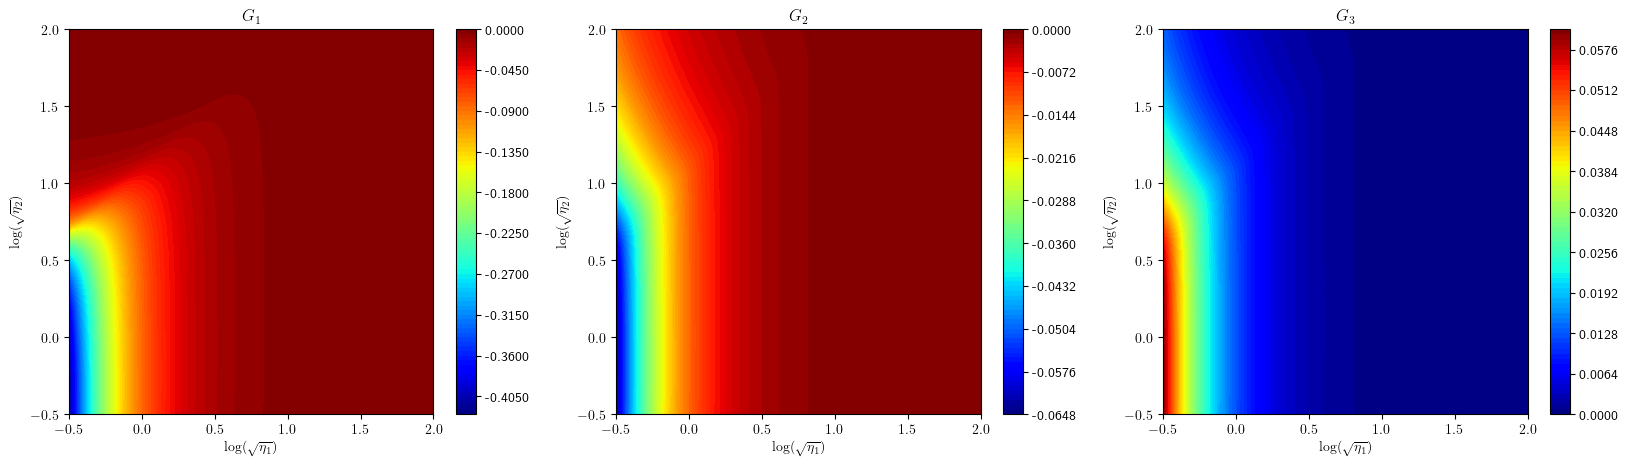

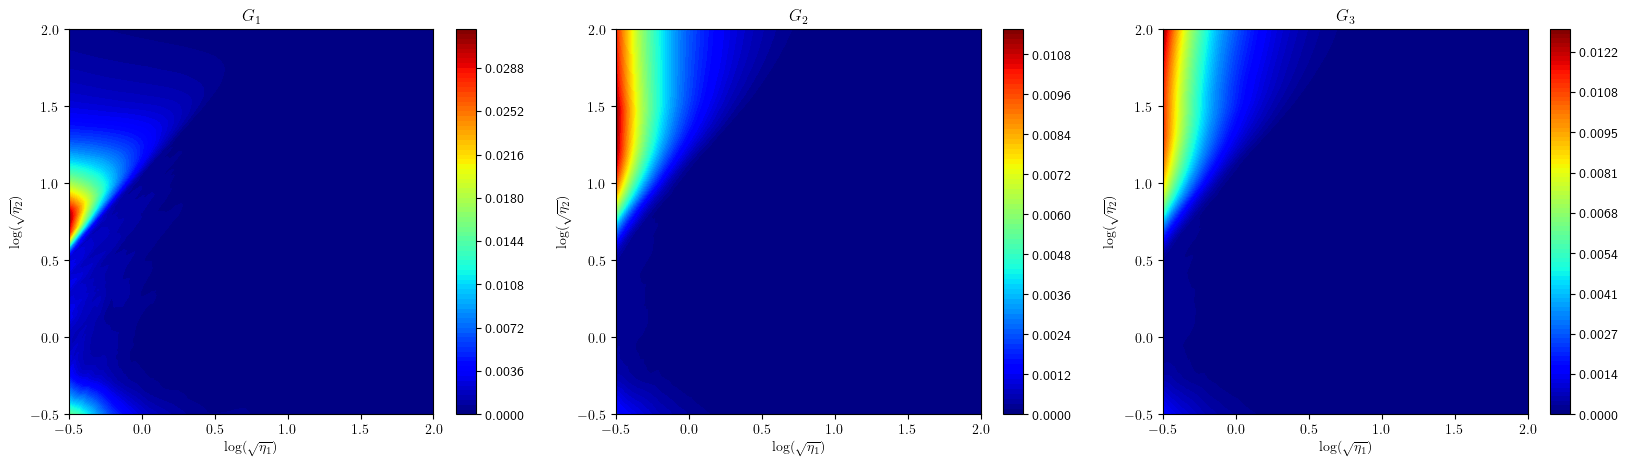

In [26]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)

pred = np.loadtxt('../data/Ensemble/D_LT_0_Pred_Mean.csv', delimiter=',')
std = np.loadtxt('../data/Ensemble/D_LT_0_Pred_Std.csv', delimiter=',')

print(np.mean(np.abs(G_s - pred)))

plot_heat_map_3D(x_grid, y_grid, pred.T.reshape(3, dim, dim))
plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim))

## Visualizing Functions

In [17]:
predictions = []
for member in ensemble:
    predictions.append(y_scaler.inverse_transform(member.predict(x_vis)).reshape(1,-1))

predictions.append(y_scaler.inverse_transform(y_vis.cpu().numpy()).reshape(1,-1))

vis_outputs = np.concatenate(predictions, axis=0)

Calculating PHATE...
  Running PHATE on 21 observations and 2400 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/home/codygrogan/.local/lib/python3.12/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (21, 2400) is expensive. Consider setting n_pca.
  warnings.warn(


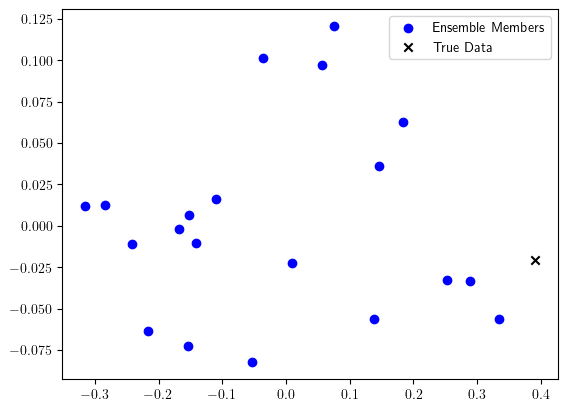

In [19]:
from phate import PHATE

phate = PHATE(n_components=2, n_jobs=4)

embedding = phate.fit_transform(vis_outputs)

plt.scatter(embedding[:-1, 0], embedding[:-1, 1], c='b', label='Ensemble Members')

plt.scatter(embedding[-1, 0], embedding[-1, 1], c='black', marker='x', label='True Data')

plt.legend()
plt.show()